In [1]:
#Reference     https://www.kaggle.com/jaykumar1607/brain-tumor-mri-classification-tensorflow-cnn

#importing all relevant libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from tensorflow.keras import backend
backend.clear_session()
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [2]:
#importing callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

In [3]:
#importing Efficientnet for transfer learning
from tensorflow.keras.applications import EfficientNetB0

In [4]:
print(tf.__version__)

2.3.0


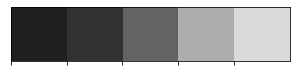

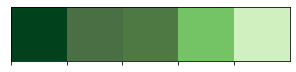

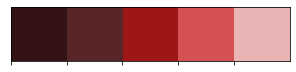

In [5]:
#reviewing colour palette
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [6]:
#Data Preperation

In [7]:
labels = ['HGG','LGG','NO_TUMOR']

In [8]:
X_train = []
y_train = []
image_size = 256
for i in labels:
    folderPath = os.path.join('Training1',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing1',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|███████████████████████████████████████████████████████████████████████████████| 627/627 [00:04<00:00, 143.77it/s]


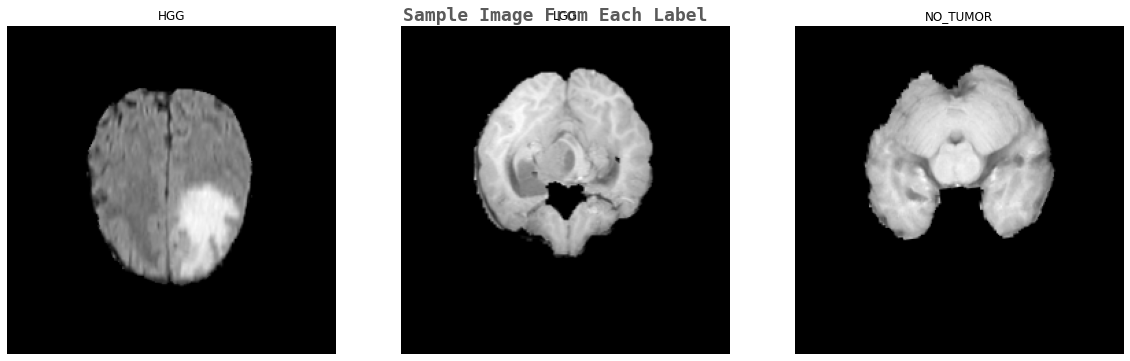

In [9]:
#Image preview
k=0
fig, ax = plt.subplots(1,3,figsize=(20,20))
fig.text(s='Sample Image From Each Label \n',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [10]:
#shuffling training data
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [11]:
y_train.shape

(19096,)

In [12]:
#split training and test data
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [13]:
#reving shape of training and test data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17186, 240, 240, 3) (1910, 240, 240, 3) (17186,) (1910,)


In [14]:
#Performing One Hot Encoding on the labels after converting it into numerical values:

#appending labels to training images within arrays
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

#appending labels to testing images within arrays
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [16]:
#reusing model weights from pretrained that were developed  for standard computer vision
#using EfficientNetB0 model which uses weights from ImageNet
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [26]:
#Global Average Pooling: acts similar to Max Pooling in CNNs however uses mean values instead of Max values which reduces the need for more compute power
#Droupout: omits neurons at various steps making neurons more independent from the neighbouring neurons. Prevents overfitting and neurons are ommitted randomly.
#Dense: This is the output layer that classifies the image into1 of the 3 possible outcomes. Softmax function is utilized as a generalization of sigmoid function.
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(3,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [27]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 240, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 240, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 241, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [28]:
#compiling model
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [29]:
#Callback parameters: helps to prevent overfitting by early stops defined by functions and rules
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [30]:
#fit model
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
  1/484 [..............................] - ETA: 1s - loss: 1.0330 - accuracy: 0.4375WARNING:tensorflow:From C:\Users\SAMUELJE\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
484/484 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.6884 
Epoch 00001: val_accuracy improved from -inf to 0.63002, saving model to effnet.h5
484/484 [==============================] - 7795s 16s/step - loss: 0.6720 - accuracy: 0.6884 - val_loss: 0.8513 - val_accuracy: 0.6300
Epoch 2/12
484/484 [==============================] - ETA: 0s - loss: 0.4996 - accuracy: 0.7863 
Epoch 00002: val_accuracy improved from 0.63002 to 0.77778, saving model to effnet.h5
484/484 [==============================] - 8444s 17s/step - loss: 0.4996 - accuracy: 0.7863 - val_loss: 0.5373 - val_accuracy: 0.7778


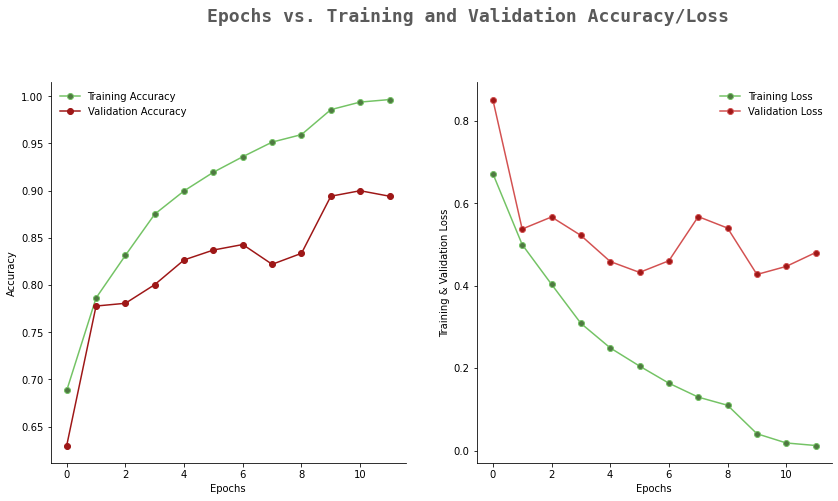

In [38]:
#view performance of modls from graphs
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = np.array(history.history['accuracy'])
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[2],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [32]:
#Review Prediction results
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [33]:
#review prediction accuracy for each class and overall
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1086
           1       0.91      0.83      0.87       398
           2       0.88      0.84      0.86       426

    accuracy                           0.90      1910
   macro avg       0.90      0.87      0.89      1910
weighted avg       0.90      0.90      0.90      1910



In [39]:
#saving models
model.save('models/brats2019_imagenet_class.h5')
model.save_weights('models/brats2019_imagenet_class.hdf5')